In [46]:
# Khai báo dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from xgboost import plot_importance, plot_tree
import sqlalchemy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Make mysql connection
url = "mysql+mysqldb://root:@localhost/weather_iot"
engine = sqlalchemy.create_engine(url)

In [7]:
df = pd.read_csv("./weather.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   province  181960 non-null  object 
 1   max       181960 non-null  int64  
 2   min       181960 non-null  int64  
 3   wind      181960 non-null  int64  
 4   wind_d    181960 non-null  object 
 5   rain      181960 non-null  float64
 6   humidi    181960 non-null  int64  
 7   cloud     181960 non-null  int64  
 8   pressure  181960 non-null  int64  
 9   date      181960 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 13.9+ MB


In [10]:
# save data to sensor table 
df.to_sql('sensor', con=engine, if_exists='replace', index=False)

181960

In [11]:
df_sensor = pd.read_sql_table('sensor', con=engine)

In [ ]:
# list province from sensor table
df_province = pd.read_sql_table('sensor', con=engine, columns=['province'])
df_province = df_province.drop_duplicates()
df_province

In [16]:
df_province

In [23]:
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   province  181960 non-null  object 
 1   max       181960 non-null  int64  
 2   min       181960 non-null  int64  
 3   wind      181960 non-null  int64  
 4   wind_d    181960 non-null  object 
 5   rain      181960 non-null  float64
 6   humidi    181960 non-null  int64  
 7   cloud     181960 non-null  int64  
 8   pressure  181960 non-null  int64  
 9   date      181960 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 13.9+ MB


In [24]:
province_select = "Ha Noi"

In [26]:
# filter
df_province = df[df['province'].isin([province_select])] 
df_province.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date
136410,Ha Noi,19,12,6,NNE,0.0,70,44,1025,2009-01-01
136411,Ha Noi,18,17,5,NNE,4.4,92,100,1015,2010-01-01
136412,Ha Noi,20,15,5,E,0.8,85,66,1015,2011-01-01
136413,Ha Noi,20,16,5,ESE,0.0,66,76,1021,2012-01-01
136414,Ha Noi,20,11,4,SE,0.0,43,29,1019,2013-01-01


In [32]:
# Lọc ra dữ liệu của Hà Nội
df_province = df[df['province'].isin(['Ha Noi'])] 

# Sắp xếp lại giá trị theo thứ tự ngày
df_province.sort_values(by=['date'])

# Tách ngày, tháng, năm ra từ cột date
df_province['day'] = df_province['date'].apply(lambda x: x.split('-')[2]).astype(int)
df_province['month'] = df_province['date'].apply(lambda x: x.split('-')[1]).astype(int)
df_province['year'] = df_province['date'].apply(lambda x: x.split('-')[0]).astype(int)

# Đặt lại index là cột date
df_province = df_province.set_index("date")

# Sắp xếp lại dữ liệu theo thứ tự ngày
df_province.sort_index(inplace=True)
df_province.head()

C:\Users\nguyen\AppData\Local\Temp\ipykernel_22836\4163450341.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_province['day'] = df_province['date'].apply(lambda x: x.split('-')[2]).astype(int)
C:\Users\nguyen\AppData\Local\Temp\ipykernel_22836\4163450341.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_province['month'] = df_province['date'].apply(lambda x: x.split('-')[1]).astype(int)
C:\Users\nguyen\AppData\Local\Temp\ipykernel_22836\4163450341.py:10: SettingWithCopyWarning: 
A value is tryin

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,day,month,year
date,,,,,,,,,,,,
2009-01-01,Ha Noi,19,12,6,NNE,0.0,70,44,1025,1,1,2009
2009-01-02,Ha Noi,18,12,6,ESE,0.5,65,28,1025,2,1,2009
2009-01-03,Ha Noi,20,13,5,ESE,0.7,74,40,1022,3,1,2009
2009-01-04,Ha Noi,25,12,5,SSW,0.0,81,46,1018,4,1,2009
2009-01-05,Ha Noi,23,14,5,S,1.3,90,75,1017,5,1,2009


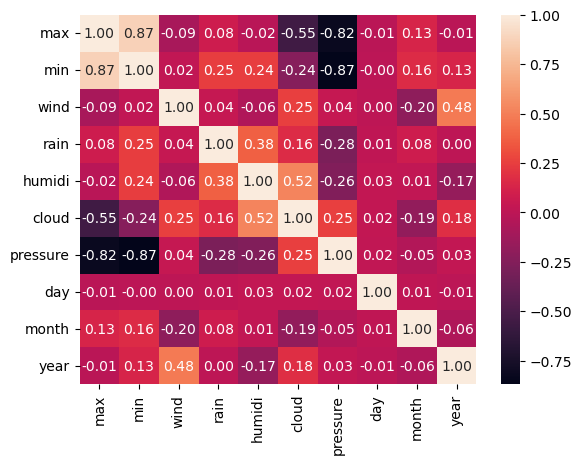

In [33]:
df_province.corr()
# plot correlation
sns.heatmap(df_province.corr(), annot=True, fmt=".2f")
plt.show()


In [12]:
# df to mysql
df.corr().to_sql(name='weather_corr', con=engine, if_exists = 'replace', index=False)

7

## Data virtualization

<AxesSubplot:xlabel='date'>

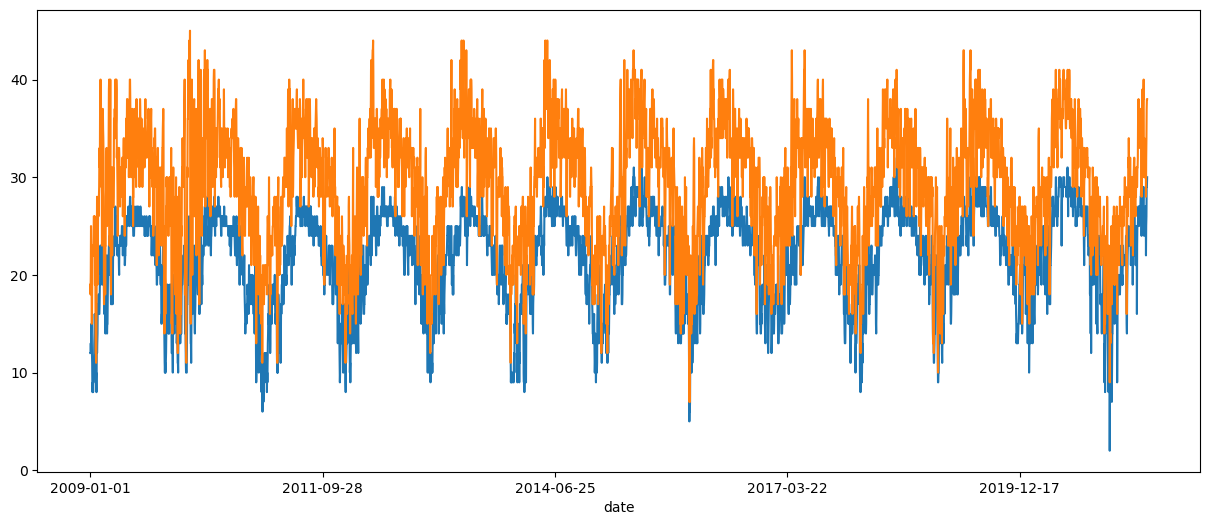

In [34]:
df_province['min'].plot(figsize=(15, 6))
df_province['max'].plot(figsize=(15, 6))

<AxesSubplot:xlabel='date'>

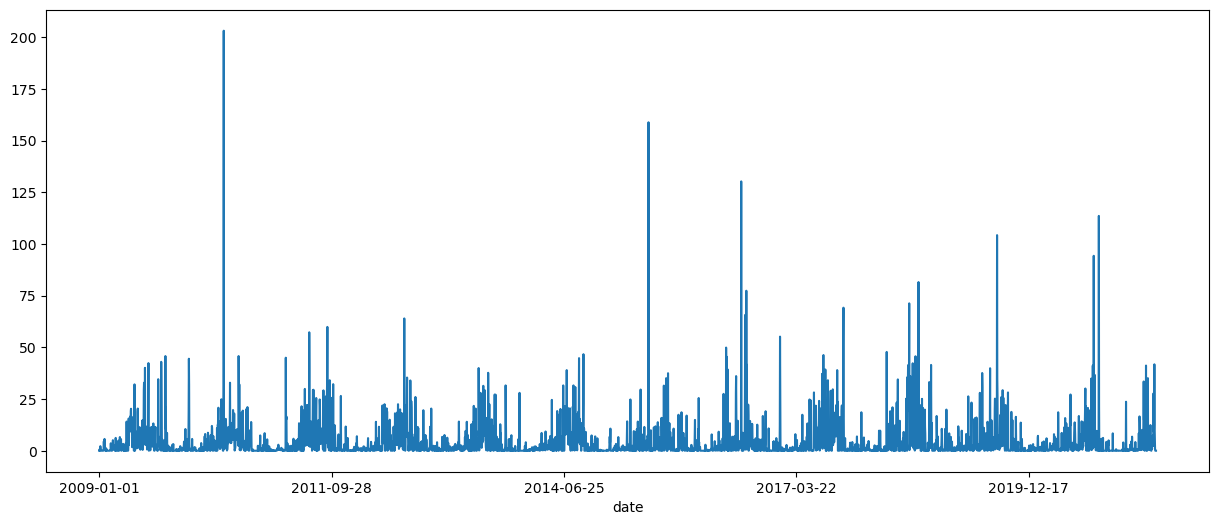

In [35]:
# plot rain
df_province['rain'].plot(figsize=(15, 6))

<AxesSubplot:xlabel='date'>

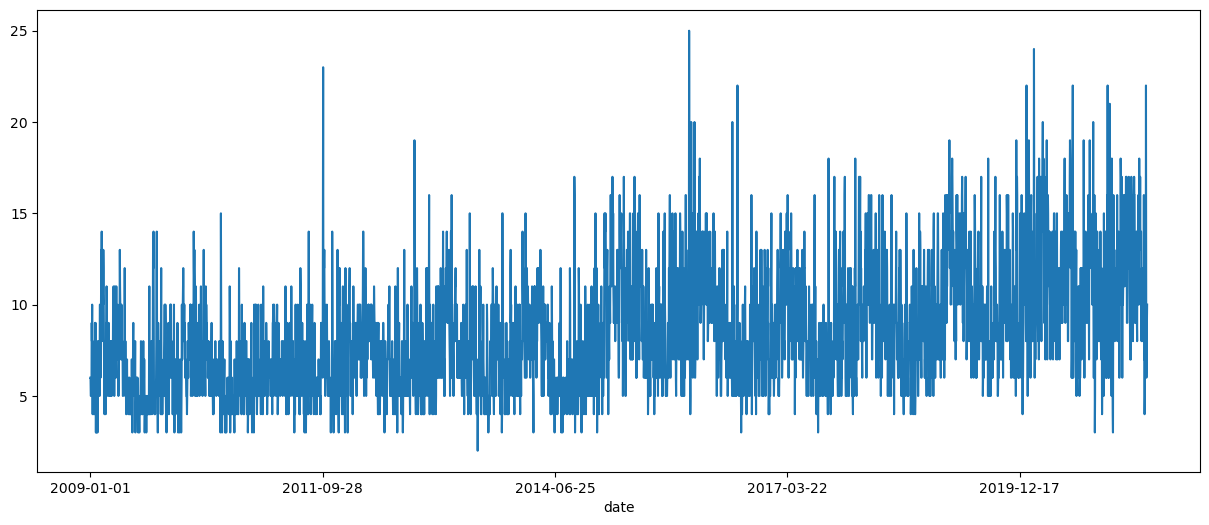

In [39]:
# plot humidity
df_province['wind'].plot(figsize=(15, 6))

<AxesSubplot:xlabel='date'>

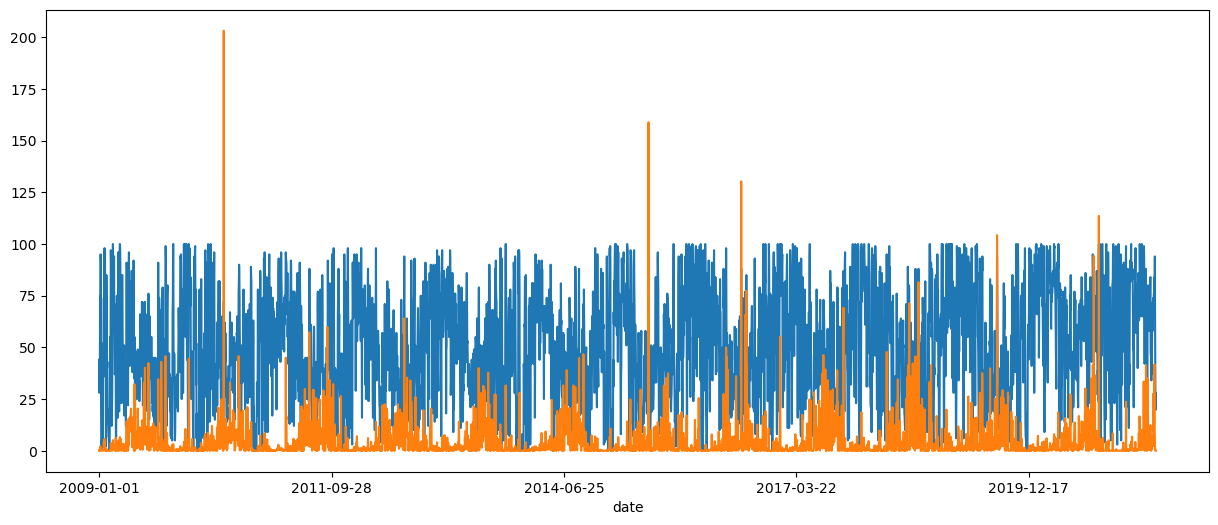

In [41]:
# draw cloud
df_province['cloud'].plot(figsize=(15, 6))
# draw rain
df_province['rain'].plot(figsize=(15, 6))

## Model

['humidi', 'pressure', 'day', 'month', 'year']


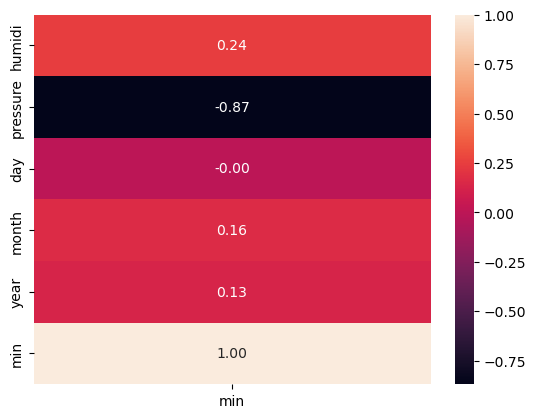

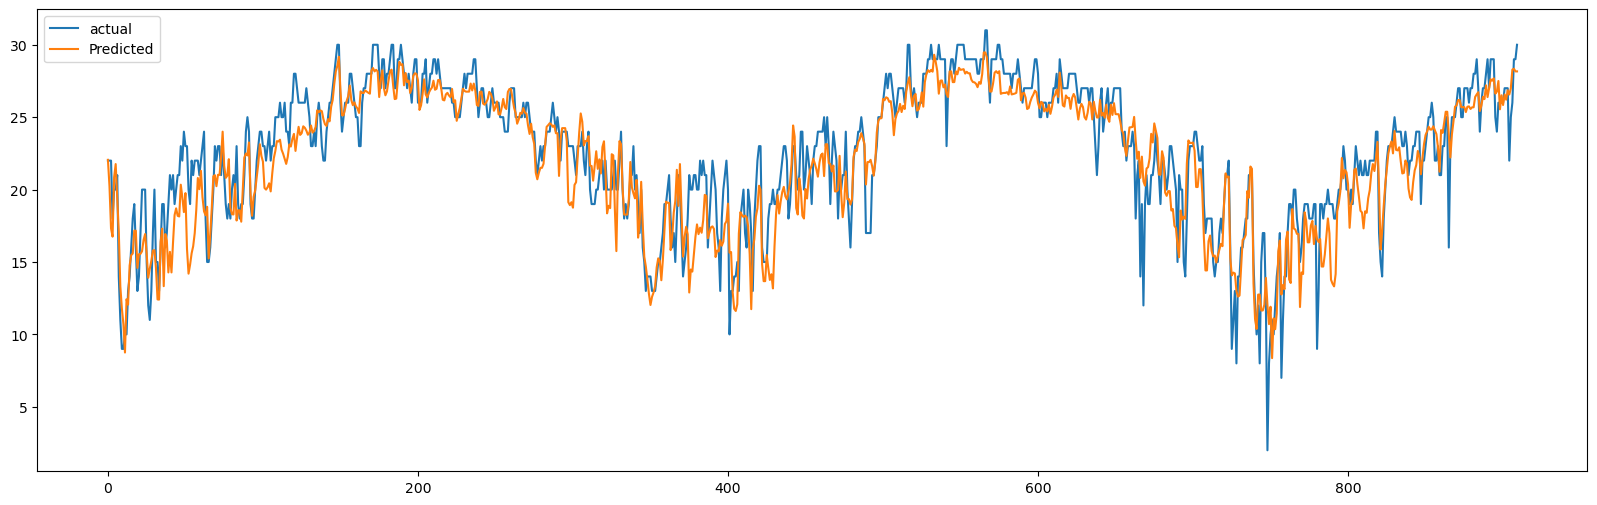

r2 score:  0.7945571187825001
rmse:  2.15215258274882


In [102]:
from pmdarima.model_selection import train_test_split

def auto_train(df_province,feature_select,label_select ):
    x_train,x_test = train_test_split(df_province, train_size=0.8)
    # train split
    X_train = x_train[feature_select]
    y_train = x_train[label_select]

    # test split
    X_test = x_test[feature_select]
    y_test = x_test[label_select]

    # fit model
    reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # too much logs 

    # predict
    pred = reg.predict(X_test)
    plt.figure(figsize=(20, 6))
    # reset index to plot 

    plt.plot(y_test.reset_index(drop=True), label='actual')

    plt.plot(pred, label='Predicted')

    plt.legend()
    plt.show()

    # error
    # r2 and rmse
    from sklearn.metrics import r2_score, mean_squared_error
    print('r2 score: ', r2_score(y_test, pred))
    print('rmse: ', np.sqrt(mean_squared_error(y_test, pred)))
    return reg

# select feature
label_select = 'min'
feature_select = df_province.columns.drop([label_select] + ["wind_d", "province", "max", "wind", "cloud", "rain"]).tolist()
# plot corr with label
label_corr =  df_province[feature_select + [label_select]].corr()[label_select]
# plot corr
sns.heatmap(label_corr.to_frame(), annot=True, fmt=".2f")

print(feature_select)

reg = auto_train(df_province,feature_select,label_select)


In [103]:
# make function to predict
# ['humidi', 'pressure', 'day', 'month', 'year']
def predict(model, feature_value):
    input = np.array(feature_value).reshape(1, -1)
    return model.predict(input)


predict(reg, [88,1017,9,12,2022])

array([16.243889], dtype=float32)

In [43]:
# Import train_test_split from pmdarima.model_selection
from pmdarima.model_selection import train_test_split

# Split data into training and testing sets
x_train,x_test = train_test_split(df_province, train_size=0.8)

In [71]:
# train split
X_train = x_train[feature_select]
y_train = x_train[label_select]

# test split
X_test = x_test[feature_select]
y_test = x_test[label_select]

In [72]:
reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # too much logs 

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type='weight',
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

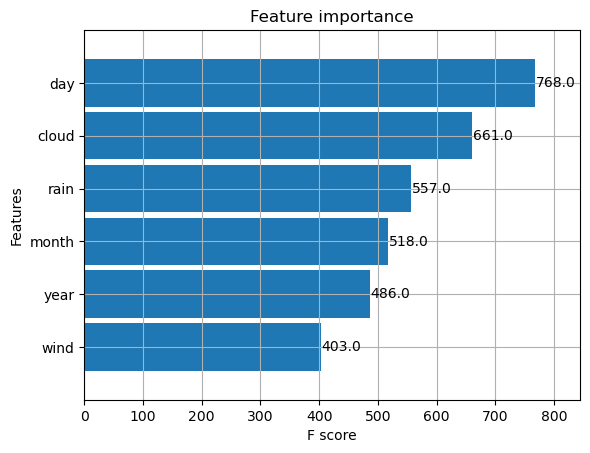

In [62]:
plot_importance(reg, height=0.9)

In [54]:
# save model
import pickle
pickle.dump(reg, open("model.pkl", "wb"))


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

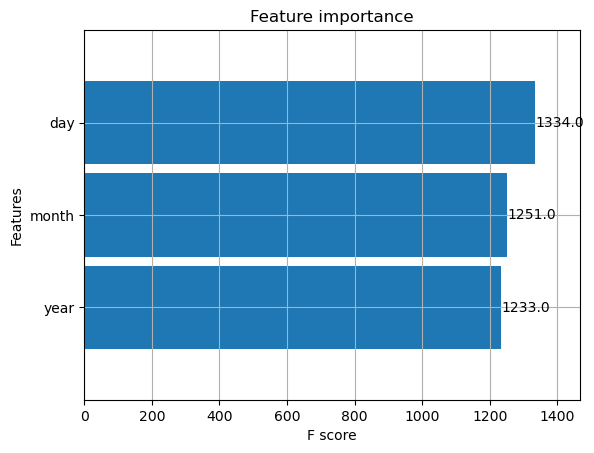

In [61]:
# load model
model = pickle.load(open("model.pkl", "rb"))
plot_importance(model, height=0.9)

In [ ]:
plot_tree(reg, num_trees=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

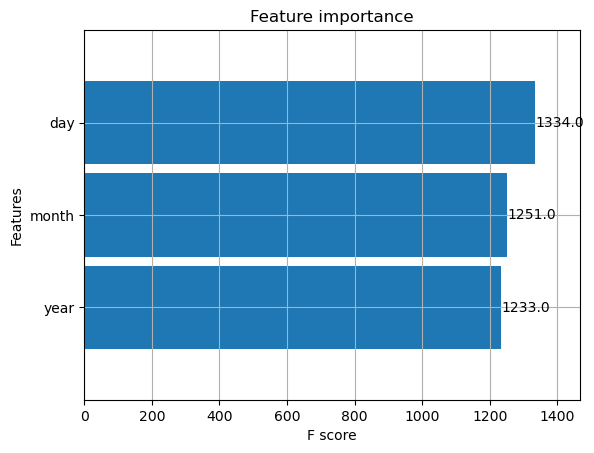

In [51]:
plot_importance(reg, height=0.9)

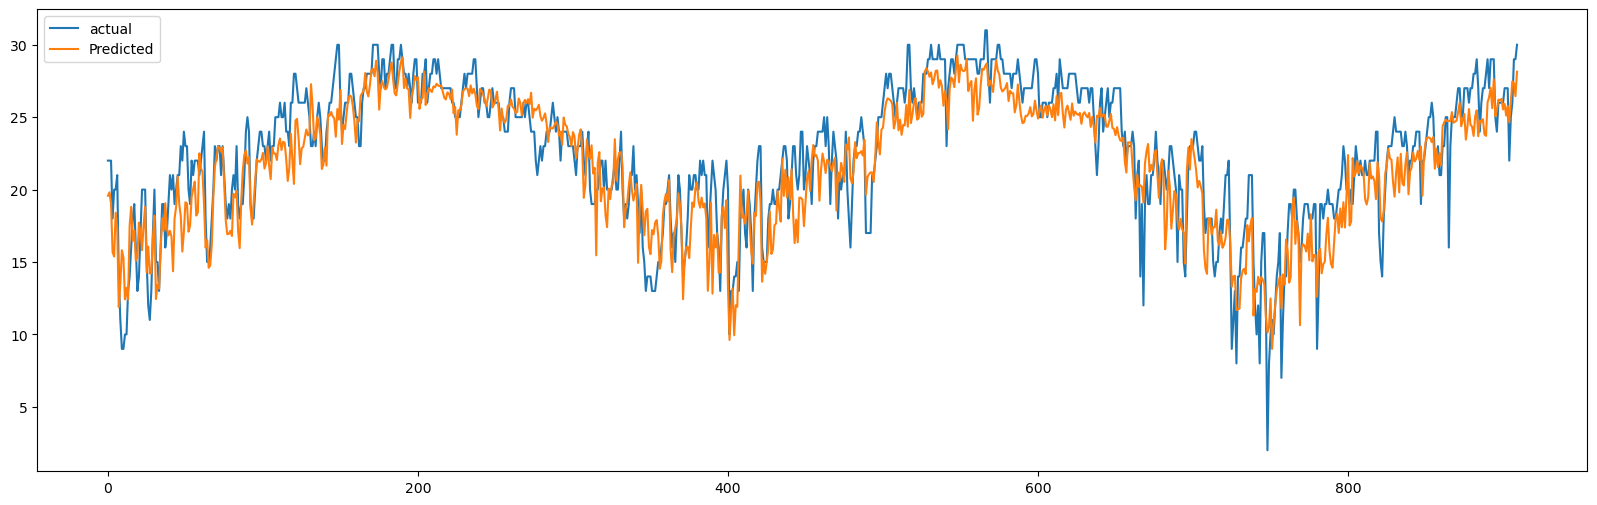

In [73]:
pred = reg.predict(X_test)
plt.figure(figsize=(20, 6))
# reset index to plot
# 

plt.plot(y_test.reset_index(drop=True), label='actual')

plt.plot(pred, label='Predicted')

plt.legend()
plt.show()


In [75]:
# r2 and rmse
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: ', r2_score(y_test, pred))
print('rmse: ', np.sqrt(mean_squared_error(y_test, pred)))


r2 score:  0.7675717211122761
rmse:  2.289138096874382
